In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"./data/{prefix}_message_5.csv"
orderbook_data_file = f"./data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction'
))

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)
df['event_lapse'] = df['time'].diff().fillna(0)

In [22]:
tick_size = 100

def calcRefPrice(row):
    midprice = (row['bid1_price'] + row["ask1_price"]) / 2 
    midpricePlusTick = midprice + tick_size / 2 
    midpriceSubTick = midprice - tick_size / 2 

    if(row['bid1_price'] - row["ask1_price"] == tick_size):
        return midprice
    else:
        if(row['ask1_price'] > row["bid1_price"]):
            return midpricePlusTick
        else:
            return midpriceSubTick

df['reference_price'] = df.apply(calcRefPrice, axis=1)

In [28]:
DEPTH = 3
ORDER_TYPES = 3

NORMALIZED_QUEUE_MAX = 50

# Orderbook depth, ordertype (limit, market, cancelation), depth of queue storage we are tracking
lambdas = np.zeros((DEPTH, ORDER_TYPES, NORMALIZED_QUEUE_MAX))


event_in_queue = [
    (df['reference_price'] + 1 * tick_size == df['price']) | (df['reference_price'] - 1 * tick_size == df['price']),
    (df['reference_price'] + 2 * tick_size == df['price']) | (df['reference_price'] - 2 * tick_size == df['price']),
    (df['reference_price'] + 3 * tick_size == df['price']) | (df['reference_price'] - 3 * tick_size == df['price'])
]

average_event_size_per_queue = [
    df[event_in_queue[0]]['size'].mean(),
    df[event_in_queue[1]]['size'].mean(),
    df[event_in_queue[2]]['size'].mean()
]

for depth_level in range(0, DEPTH):
    df_at_depth = df.loc[event_in_queue[depth_level]]
    
    for queue_length_index in range(0, NORMALIZED_QUEUE_MAX):
        bidMatchesNormalizedQueue = (np.ceil(df_at_depth[f'bid{depth_level + 1}_size'].astype(float) / average_event_size_per_queue[depth_level]) == queue_length_index)
        askMatchesNormalizedQueue = (np.ceil(df_at_depth[f'ask{depth_level + 1}_size'].astype(float) / average_event_size_per_queue[depth_level]) == queue_length_index)
        
        matchesNormalizedQueue = (bidMatchesNormalizedQueue | askMatchesNormalizedQueue)

        df_at_queue = df_at_depth.loc[matchesNormalizedQueue]

        isLimitOrder = (df_at_queue['type'] == 1)

        isMarketOrder = (df_at_queue['type'] == 4) | (df_at_queue['type'] == 5)

        isCancelOrder = (df_at_queue['type'] == 2) | (df_at_queue['type'] == 3)

        numb_orders_matching_norm_queue = len(df_at_queue)

        dt_order = df_at_queue['time'].diff().fillna(0).mean()

        lambdas[depth_level, 0, queue_length_index] = len(df_at_queue[isLimitOrder]) / (numb_orders_matching_norm_queue * dt_order)
        lambdas[depth_level, 1, queue_length_index] = len(df_at_queue[isMarketOrder]) / (numb_orders_matching_norm_queue * dt_order)
        lambdas[depth_level, 2, queue_length_index] = len(df_at_queue[isCancelOrder]) / (numb_orders_matching_norm_queue * dt_order)

        # 
        # LAMBDA DEBUG STATEMENTS
        # 

        print(len(df_at_queue[isCancelOrder]), numb_orders_matching_norm_queue, dt_order)
        # if(queue_length_index == 1 and depth_level > 0):
        #     pd.options.display.max_rows = None
        #     pd.options.display.max_columns = None

        #     print("Depth", depth_level + 1)
        #     # Sum of time differences
        #     print("Sum of time differences:", df_at_queue[isLimitOrder]['time'])
        #     print("Sum of time differences:", df_at_queue[isLimitOrder]['time'].diff().fillna(0))
            
        #     print(df_at_queue[isLimitOrder]['time'].diff().fillna(0).sum())
        #     print(len(df_at_queue[isLimitOrder]['time'].diff().fillna(0)))

            # plt.plot(df_at_queue[isLimitOrder]["time"].diff().fillna(0))
            # plt.title("DT-L")
            # plt.show()
            # plt.plot(df_at_queue[isMarketOrder]["time"].diff().fillna(0))
            # plt.title("DT-M")
            # plt.show()
            # plt.plot(df_at_queue[isCancelOrder]["time"].diff().fillna(0))
            # plt.title("DT-C")
            # plt.show()

            # print("N", numb_orders_matching_norm_queue)
            # print("L", len(df_at_queue[isLimitOrder]))
            # print(dt_limit)
            # print("M", len(df_at_queue[isMarketOrder]))
            # print(dt_market)
            # print("C", len(df_at_queue[isCancelOrder]))
            # print(dt_cancel)
            # print("AES", np.mean(df_at_queue['size']))
    print()

0 0 nan
2203 6233 3.75386404086764
1503 4368 5.356604635074176
1697 4766 4.909241200240033
1462 3993 5.858455756598797
1725 4484 5.217577537304861
2298 5531 4.230131438162899
1700 4329 5.4042346258403775
1901 4557 5.131880758010314
2071 4764 4.908424704453611
1922 4442 5.249740384198334
2585 5966 3.906522447419879
2506 5636 4.15068068037296
2430 5581 4.17085206037556
2628 6223 3.7405248331809418
2841 6352 3.6641869560818643
2997 6734 3.4562808188106615
3387 7327 3.177051608755016
3261 6955 3.3470005901233644
3441 7539 3.0877271085775306
3330 7443 3.1269343568864705
3447 7600 3.062540650570264
3538 7933 2.934389411855036
3410 7441 3.1274293603452494
3643 7975 2.894934921382194
3851 8513 2.713004204375661
3738 8601 2.7030657666122546
3892 8832 2.632367370079597
4237 9409 2.4540126236379
3797 8363 2.7616601283242854
3779 8330 2.7710812989944777
3534 8045 2.868881536403854
3260 7020 3.3119802030185186
3083 6896 3.371271434042344
3210 6971 3.292962420876489
3133 6848 3.395152588834405
3026 

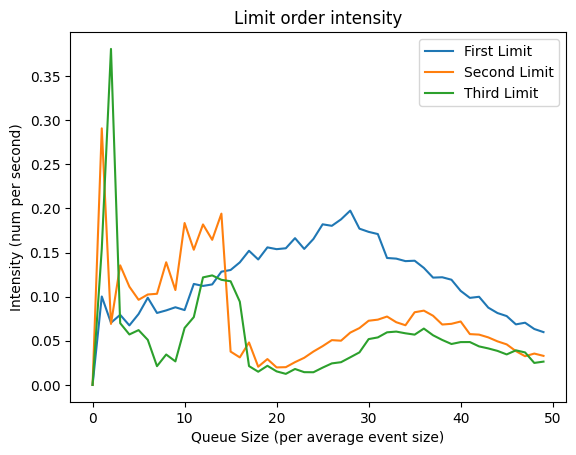

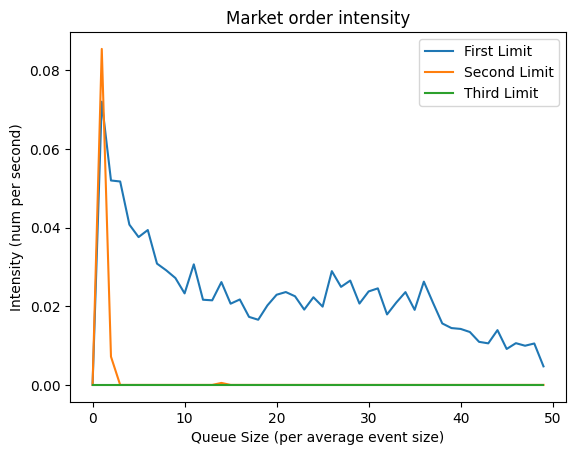

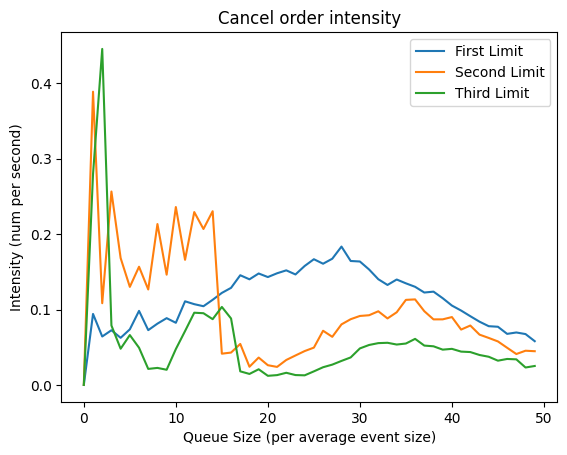

In [24]:
for i in range(0, ORDER_TYPES):
    lambdas[0][i][np.isnan(lambdas[0][i])] = 0
    lambdas[1][i][np.isnan(lambdas[1][i])] = 0
    lambdas[2][i][np.isnan(lambdas[2][i])] = 0
    plt.plot(lambdas[0][i], label="First Limit")

    plt.plot(lambdas[1][i], label="Second Limit")

    plt.plot(lambdas[2][i], label="Third Limit")

    plt.ylabel("Intensity (num per second)")

    plt.xlabel("Queue Size (per average event size)")

    plt.legend()
    if (i == 0):
        order_type = "Limit"
    elif (i == 1):
        order_type = "Market"
    else:
        order_type = "Cancel"

    plt.title(f"{order_type} order intensity")

    plt.show()